# Compute latency

This notebook allows you to compute the end-to-end latency of the OVMF. 
Please refer to the documentation [here](../INSTALLATION.md#4-latency-calibration).

## Packages and functions

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, fft, ifft
import os, sys

# Taken from https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
def smooth(x,window_len=12,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also: 

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError ("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError ("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    y=y[ int (window_len/2-1):- int (window_len/2)]
    return y

def smoothData(data, window_len = 20):
    import copy
    data = copy.copy(data)
    for i in range (data.shape[1]):
        data[i] = smooth(data[i],window_len)
    return data


def normalize(data, invert = False):
    import copy
    d = copy.copy(data)
    for i in range (d.shape[1]):
        if invert & (d[i].min() < 0):
             d[i] = -1 * d[i]
        # min = data[i].min()
        # if (min < 0):
        #     data[i] = data[i].add(abs(min))

        d[i] -= d[i].mean()
        d[i] /= d[i].std()

        #data[i] -= data[i].mean(); data[i] /= data[i].std()
    return d

def filter(data , number=100):
    for i in range (data.shape[1]):
        originalf = fft(data[i])
        originalf[number:] = 0
        data[i] = ifft(originalf)
    return data


## Parameters

In [237]:
# The amount of frames from the beginning of the sequence will be dropped
cutoff = 80

# The window size for smoothing, the longer the smoother
smooth_win_len = 20

# The frames per second (fps) with which the video of both avatars has been recorded, e.g., with a mobile camera. 
fps=120

# The length of the subsamples, should be about 1.5 times the length of the head movement, i.e. 
wsize = int(2 * fps * 1.5)

# The filename of the csv generated by OpenFace that contains the tracking data
filename="processed/<filename>.csv"

## Import CSV with OpenFace tracking

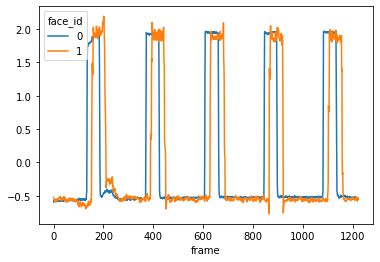

In [238]:
# Read data
df = pd.read_csv(filename,skipinitialspace=True)
df = pd.pivot_table(df, values='pose_Ry', columns='face_id' , index=['frame'] )

# Z-Transformation (with inversion)
df = normalize(df, invert = True)

# Generate Plot
plot = df.plot(kind='line')
plt.show()



## Adjust the OpenFace tracking ids

Please select the face_ids of the face in prerecorded video (here called the *reference_face_id*) and the avatar face (*compare_face_id*) using the plot above.

The reference face will turn first, and the avatar follows with the delay we want to compute.

In [239]:
reference_face_id=0
compare_face_id=1

## Data cleaning and smoothing

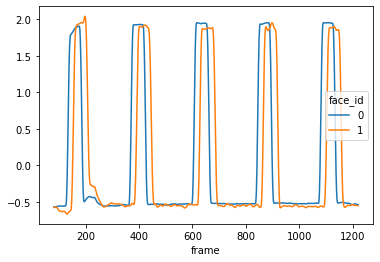

In [240]:
# Select the two faces only
df=df.loc[:,[reference_face_id, compare_face_id]]


# cutoff the first frames
df = df.drop(df.index[np.arange(0,cutoff)])

#drop Nan's - If needed, uncomment this code
# df_nan = df.isnull()
# df_drop_nan = df
# for i in range (df.shape[1]):
#     if not (np.any(df[i]==False)):
#         continue
#     first_occ = df_nan[i][df_nan[i]==False].index[0]
#     df_drop_nan = df.drop(df.index[np.arange(0,first_occ)])
# df = df_drop_nan

#smoothing the Data
df_smooth= smoothData(df, window_len=smooth_win_len)

df_smooth.plot(kind='line')
plt.show()


## Signal correlation and shift computation

If you encounter an error, check whether the tracking ids of OpenFace were correctly set.

In [241]:

frame_shifts = []
if wsize >= df_smooth.shape[0]:
    raise Exception("Wsize for subsamples exceeds number of frames in the video")

np.random.seed(seed=12345)
t=50
for t in np.random.randint(0, df_smooth.shape[0] - wsize -1, t):
    df_sub = df_smooth.iloc[range(t,t+wsize),]
    original = df_sub[reference_face_id]
    shifted = df_sub[compare_face_id]
    nsamples = original.size
    corr = signal.correlate(shifted,original)
    dt = np.arange(-nsamples, nsamples-1)
    shift = dt[corr.argmax()]
    if shift < 0:
        continue
    frame_shifts += [shift]

if len(frame_shifts) == 0:
    raise Exception("Could not compute shift. Check tracking ids!")

frame_shifts = np.array(frame_shifts) * 1000 / fps
print("Average frame shift: {:.2f} ms (SD={:.2f} ms)".format(
    np.mean(frame_shifts),
    np.std(frame_shifts)
    ))
print("Min: {:.2f} ms Max: {:.2f} ms".format(
    np.min(frame_shifts),np.max(frame_shifts)
    ))

Average frame shift: 169.83 ms (SD=5.75 ms)
Min: 158.33 ms Max: 175.00 ms
